In [1]:
# Imports
import numpy as np
from numpy import argmax, argmin
from scipy.stats import norm
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel, RationalQuadratic, ExpSineSquared, DotProduct
import time
import pandas as pd
import os

# Settings
np.set_printoptions(suppress=True)

# Variables
dims = 4

In [6]:
# Parameter Space
param_bounds = [
    np.linspace(start=0, stop=5, num=21),
    np.linspace(start=10, stop=100, num=46),
    np.linspace(start=0, stop=5, num=21),
    np.linspace(start=100, stop=300, num=101)
]
param_space = np.array( np.meshgrid(param_bounds[0],
                                    param_bounds[1],
                                    param_bounds[2],
                                    param_bounds[3])).T.reshape(-1,dims)

In [7]:
csv_path = os.path.abspath(os.path.join(
    os.getcwd(),
    os.pardir,
    'datasets',
    'quality_scores.csv'
))
df = pd.read_csv(csv_path)

In [8]:
# Standardize data
def standardize(x, transform_me):
    return (transform_me - np.mean(x,axis=0)) / (np.std(x,axis=0)+1e-9)

# Reverse Standardize data
def unstandardize(x, standadized):
    std = np.std(x,axis=0)+1e-9
    mean = np.mean(x,axis=0)
    old = standadized*std + mean
    return old


# GP model predictions
def surrogate(model, x):
    return model.predict(x ,return_std=True)


# Expected Improvement (EI)
def acquisition(x_sample, param_space, model):
    Xi = 0
    yhat, _ = surrogate(model, x_sample)
    best = max(yhat)
    mu, std = surrogate(model, param_space)
    imp = (mu - best - Xi)
    with np.errstate(divide='warn'):
        z = imp / std
        probs = imp *  norm.cdf( z ) + std * norm.pdf( z )
        probs[std==0.0] = 0.0
    return probs 


# Optimal parameters using acq. function
def opt_acquisition(x_sample, param_space, model):
    scores = acquisition(x_sample,param_space, model)
    ix = argmax(scores)
    return param_space[ix], ix

In [16]:
# Initialize model
#kernel = ConstantKernel(0.00316**2, constant_value_bounds='fixed') + RBF(1.96,length_scale_bounds='fixed') + WhiteKernel(0.193, noise_level_bounds='fixed') 
kernel = ConstantKernel() + RBF() + WhiteKernel() 
model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, random_state=42)

# Define init data
x_init = np.array(df[["Param1", "Param2", "Param3", "Param4"]].iloc[:-120,:])
y_init = np.array(-df["Area sum"].iloc[:-120])

# Fit model on init data
model.fit(standardize(x_init, x_init), standardize(y_init, y_init))
mu, std = surrogate(model, standardize(x_init, param_space))

In [17]:
print(model.kernel)
print(model.kernel_)
# print(-y_init.mean())
# print( 0.00316 *  (y_init.std()+1e-9) )
# print( 5 *  (y_init.std()+1e-9) ) 

1**2 + RBF(length_scale=1) + WhiteKernel(noise_level=1)
0.525**2 + RBF(length_scale=1.95) + WhiteKernel(noise_level=0.193)


0.00316, 1.96, 0.193
------------------
0.694, 1.27, 0.193
0.715, 1.29, 0.198
0.761, 1.33, 0.195
0.755, 1.35, 0.195
0.724, 1.35, 0.194
0.645, 1.37, 0.195
0.633, 1.48, 0.193
0.678, 1.52, 0.195
0.634, 1.53, 0.195
0.525, 1.95, 0.193

After changing pre-processing method, hyperparams went from:
0.00316, 1.96, 0.193
to
0.525, 1.95, 0.193



[    772.    2338.    5274.    8743.   14551.   26072.   52631. 1610506.
  292513.   35486.]
[-9375.08393549 -8624.71852429 -7874.3531131  -7123.98770191
 -6373.62229072 -5623.25687953 -4872.89146834 -4122.52605715
 -3372.16064596 -2621.79523477 -1871.42982358]


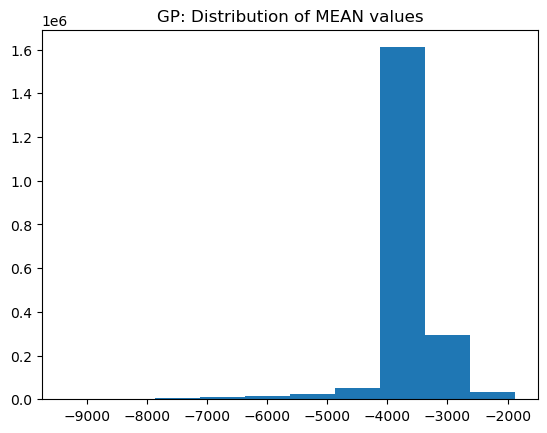

[   3896.    7553.   11446.   14136.   18176.   27845.   40492.   63194.
  113394. 1748754.]
[ 718.11535163  831.01288315  943.91041466 1056.80794617 1169.70547769
 1282.6030092  1395.50054071 1508.39807222 1621.29560374 1734.19313525
 1847.09066676]


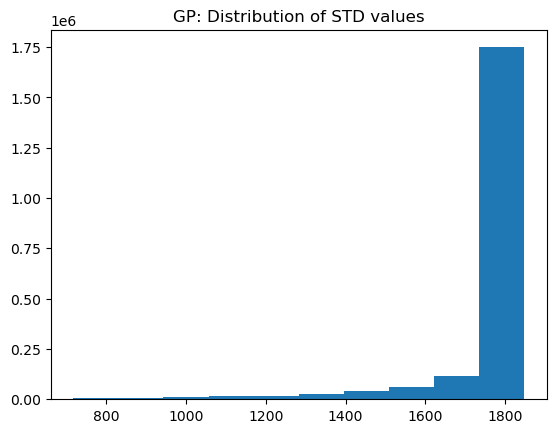

In [18]:
a, b, _ = plt.hist(unstandardize(y_init, mu))
plt.title("GP: Distribution of MEAN values")

print(a)
print(b)
plt.show()

c, d, _ = plt.hist( std * (y_init.std()+1e-9) )
plt.title("GP: Distribution of STD values")
print(c)
print(d)
plt.show()




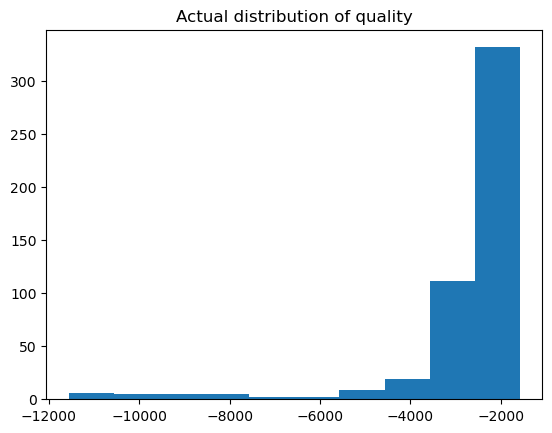

In [19]:
plt.hist(y_init)
plt.title("Actual distribution of quality")
plt.show()

In [20]:
mini_df = df[["Experiment","Index","Param1", "Param2", "Param3", "Param4", "Area sum"]]
grouped = mini_df.groupby(["Param1", "Param2", "Param3", "Param4"]).agg({"Area sum": ['mean', 'std']}).reset_index()
mean_quality = grouped['Area sum','mean']
std_quality = grouped['Area sum','std']

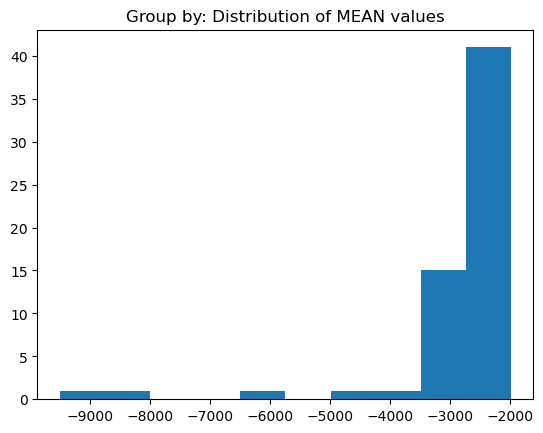

In [21]:
plt.hist(-mean_quality)
plt.title("Group by: Distribution of MEAN values")
plt.show()

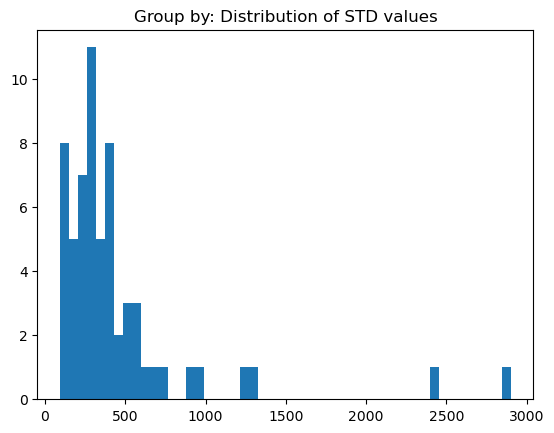

In [22]:
plt.hist(std_quality,bins=50)
plt.title("Group by: Distribution of STD values")
plt.show()

# Evaluation on training points

In [23]:
pred = model.predict(standardize(x_init, x_init))

Sum of Diffs 204842.33555404533


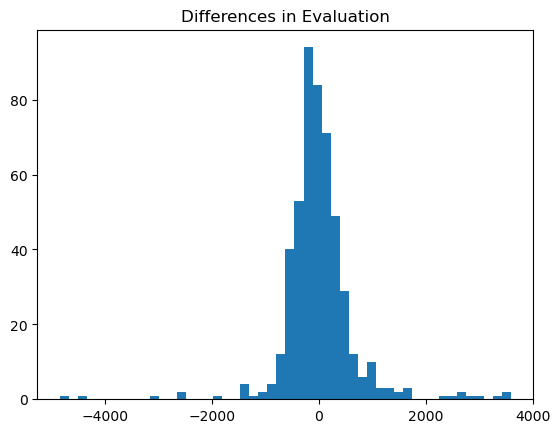

In [24]:
# diff = pred -  standardize(y_init, y_init)
diff = unstandardize(y_init, pred) - y_init
print("Sum of Diffs", np.sum(abs(diff)))
plt.hist(diff,bins=50)
plt.title("Differences in Evaluation")
plt.show()

# Suggestions

In [356]:
# Calculate best point to sample
best_x, ix = opt_acquisition(x_init,standardize(x_init, param_space),model)
print(f"Best point: {unstandardize(x_init,best_x)}")

Best point: [  2.  58.   2. 220.]


In [380]:
# Calculate estimate and deviation (mean and std)
best_x = [2,58,2,220]
est_mean, est_std = surrogate(model, [best_x]) # .reshape(-1,1)
est_mean = unstandardize(y_init, est_mean)
est_std  = est_std * (y_init.std()+1e-9)
print(f"Estimated mean: {int(-est_mean)} with deviation: {est_std}")

Estimated mean: 2792 with deviation: [1775.44764238]
